In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Creating a model from scratch and training it
# First pass is always the same samples at random as the previous step


# Active learning with Trieste

In [3]:
import trieste
from trieste.models import FastUpdateModel
from trieste.models.gpflow import VariationalGaussianProcess, SparseGaussianProcessRegression, GaussianProcessRegression
from trieste.models.gpflow.builders import build_vgp_classifier
from trieste.objectives.utils import mk_observer
from trieste.experimental.plotting import plot_model_predictions_plotly, add_bo_points_plotly

import tensorflow as tf
from functools import partial
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

2024-04-18 10:55:53.803741: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 10:55:53.834029: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 10:55:53.834055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 10:55:53.834821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 10:55:53.839775: I tensorflow/core/platform/cpu_feature_guar

In [4]:
class NotImplementedReport(Exception):
    def __init__(self, message="This method is not implemented yet."):
        self.message = message
        super().__init__(self.message)

In [5]:
def circle(x, radius=0.5, noise=0, center=[0,0]):
    x_centered = x - center
    radii = tf.sqrt(tf.reduce_sum(tf.square(x_centered), axis=1, keepdims=True))
    if noise>0:
        return tf.cast((radii - radius) > 0, tf.float64)

    else:
        return tf.cast((radii - radius + noise*np.random.normal(size=radii.shape) > 0), tf.float64)
    
def log_single_var(x, noise=0, target_loc=1):
    if noise>0:
        x += 0.2*noise*np.random.norma(size=len(x))
    return tf.cast(tf.where(x>target_loc,1,0), tf.float64)     

#loc_scaled = scaler.transform(np.array([1]).reshape(-1,1))[0,0]
#noise_scaled = scaler.transform(np.array([1]).reshape(-1,1))[0,0]


2024-04-18 10:55:59.627671: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


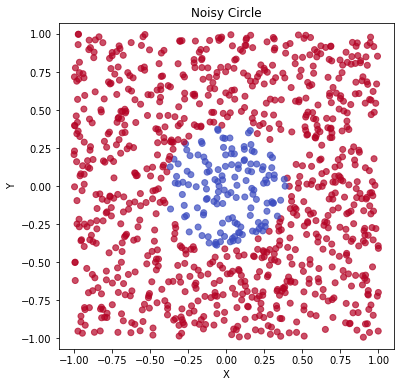

In [6]:
# Generate data
noise_scaled=0.10
num_points = 1000
x = np.random.uniform(-1, 1, size=(num_points, 2))
y = circle(x, radius=0.4, noise=noise_scaled, center=[0,0])

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x[:,0], x[:,1], c=y.numpy().flatten(), cmap='coolwarm', alpha=0.7)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

In [7]:
init_fun = partial(circle, noise=noise_scaled)
search_space = trieste.space.Box([-1,-1],[1,1])
num_initial_points=30
X = search_space.sample(num_initial_points)
observer = mk_observer(init_fun)
initial_data = observer(X)

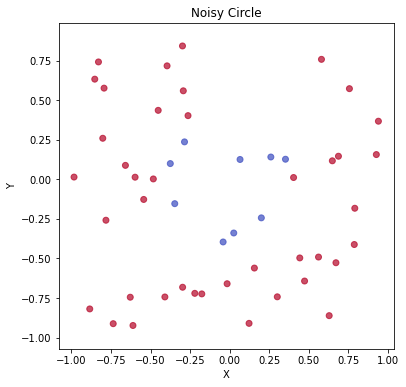

In [8]:
from trieste.data import Dataset

num_points = 50
x = tf.cast(np.random.uniform(-1, 1, size=(num_points, 2)), dtype=tf.float64)
y = circle(x, radius=0.4, noise=noise_scaled, center=[0,0])

plt.figure(figsize=(6, 6))
plt.scatter(x[:,0], x[:,1], c=y.numpy().flatten(), cmap='coolwarm', alpha=0.7)
plt.title('Noisy Circle')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()

initial_data = Dataset(x, y)

In [9]:
# y

In [10]:
# TODO expand build_vgp_classifier to accept inducing points
# Speed up wherever possible. @Tf functions or so

# online_model = VariationalGaussianProcess(
#     build_vgp_classifier(initial_data, search_space, noise_free=True)
# )
import tensorflow as tf
#KERNEL_LENGTHSCALE = tf.cast(0.2, dtype=gpflow.default_float())
from trieste.space import Box, SearchSpace
from trieste.models.gpflow import SparseVariational, build_svgp, KMeansInducingPointSelector
import tensorflow as tf
from typing import Optional, Sequence, Type
from typing import Callable, Hashable, Tuple, TypeVar, Union
from gpflow.models import GPR, SGPR, SVGP, VGP, GPModel
import math
import gpflow
import tensorflow_probability as tfp
from trieste.models.gpflow.builders import *
from trieste.models.gpflow.builders import _set_gaussian_likelihood_variance
from gpflow.likelihoods import Bernoulli
import warnings
TensorType = Union[tf.Tensor, tf.Variable]
        
def _get_inducing_points(
    search_space: SearchSpace, num_inducing_points: Optional[int]
) -> TensorType:
    if num_inducing_points is not None:
        tf.debugging.assert_positive(num_inducing_points)
    else:
        num_inducing_points = min(
            MAX_NUM_INDUCING_POINTS, NUM_INDUCING_POINTS_PER_DIM * search_space.dimension
        )
    if isinstance(search_space, Box):
        inducing_points = search_space.sample_sobol(num_inducing_points)
    else:
        inducing_points = search_space.sample(num_inducing_points)

    return inducing_points
    
def _get_data_stats(data: Dataset) -> tuple[TensorType, TensorType, int]:
    empirical_variance = tf.math.reduce_variance(data.observations)
    empirical_mean = tf.math.reduce_mean(data.observations)
    num_data_points = len(data.observations)

    return empirical_mean, empirical_variance, num_data_points
    
def _get_mean_function(mean: TensorType) -> gpflow.mean_functions.MeanFunction:
    mean_function = gpflow.mean_functions.Constant(mean)
    return mean_function
    
def _get_lengthscales(search_space: SearchSpace, default_lengthscale=2) -> TensorType:
    lengthscales = (default_lengthscale * (search_space.upper - search_space.lower) * math.sqrt(search_space.dimension))
    search_space_collapsed = tf.equal(search_space.upper, search_space.lower)
    lengthscales = tf.where(
        search_space_collapsed, tf.constant(1.0, dtype=gpflow.default_float()), lengthscales
    )
    return lengthscales
    
def _get_kernel(variance: TensorType, search_space: SearchSpace, 
                add_prior_to_lengthscale: bool, add_prior_to_variance: bool,
                lengthscale_scaling: float=1, variance_scaling: float=1) -> gpflow.kernels.Kernel:
    lengthscales = _get_lengthscales(search_space)
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=lengthscales)

    if add_prior_to_lengthscale:
        kernel.lengthscales.prior = tfp.distributions.LogNormal(
            tf.math.log(lengthscales), tf.constant(lengthscale_scaling, dtype=gpflow.default_float())
        )
    if add_prior_to_variance:
        kernel.variance.prior = tfp.distributions.LogNormal(
            tf.math.log(variance), tf.constant(variance_scaling, dtype=gpflow.default_float())
        )

    return kernel
    
def build_vgp(data: Dataset, 
              search_space: SearchSpace,
              classification: bool = False,
              sparse: bool=False,
              kernel_priors: bool = True,
              likelihood_variance: Optional[float] = None,
              trainable_likelihood: bool = False,
              noise_free: bool = False,
              kernel_variance: Optional[float] = None,
              inducing_variables: Optional[np.array] = None,
              num_inducing_points: Optional[int] = None,
              trainable_inducing_points: bool = False,
              ) -> GPModel:
    
    if noise_free and kernel_variance is not None:
        if kernel_variance > 0:
            msg = f"Noise free was specified, but kernel variance was set to {kernel_variance}. \n Kernel variance has been set to accordingly."
            raise Exception(msg)
            
    if noise_free:
        add_prior_to_variance = False
    else:
        add_prior_to_variance = kernel_priors

    empirical_mean, empirical_variance, num_data_points = _get_data_stats(data)
    
    if classification:
        if noise_free: 
            empirical_variance = tf.constant(100.0, dtype=gpflow.default_float())
        else:
            empirical_variance = tf.constant(kernel_variance, dtype=gpflow.default_float())
            
        empirical_mean = tf.constant(0.0, dtype=gpflow.default_float())
        model_likelihood = gpflow.likelihoods.Bernoulli()
        
    else:
        if noise_free: 
            empirical_variance = tf.constant(100.0, dtype=gpflow.default_float())
        elif kernel_variance:
            empirical_variance = tf.cast(kernel_variance, dtype=gpflow.default_float())
        else:
            pass
        #TODO pass other types of regression likelihoods here.
        model_likelihood = gpflow.likelihoods.Gaussian()
        
   
    kernel = _get_kernel(empirical_variance, search_space, 
                         add_prior_to_lengthscale=kernel_priors, 
                         add_prior_to_variance=add_prior_to_variance)
    
    mean = _get_mean_function(empirical_mean)

    if sparse:
        if inducing_variables is None:
            msg = "No inducing variables were provided, inducing them from search_space"
            warnings.warn(msg)
            inducing_points = _get_inducing_points(search_space, num_inducing_points)
        elif inducing_variables:
            inducing_points = inducing_variables
        elif inducing_variables is None and num_inducing_points is None:
            msg = "No inducing_variables nor num_inducing_points were specified. \n Using the initial dataset_as such"
            inducing_points = data.query_points
            
        model = SVGP(#data=(data.query_points,data.observations), 
                     kernel=kernel, 
                    likelihood=model_likelihood,
                    inducing_variable=inducing_points,
                    mean_function=mean,
            num_data=len(data.query_points)
        )
    
    elif not sparse:
        model = VGP(data.astuple(), kernel=kernel, likelihood=model_likelihood, mean_function=mean)

    if not classification:
        _set_gaussian_likelihood_variance(model, empirical_variance, likelihood_variance)
        gpflow.set_trainable(model.likelihood, trainable_likelihood)
        
    if sparse:
        gpflow.set_trainable(model.inducing_variable, trainable_inducing_points)
        #model.update(data)
    
    gpflow.set_trainable(model.kernel.variance, (not noise_free))

    return model

In [11]:
# initial_data.query_points

In [71]:
from trieste.models.optimizer import BatchOptimizer

batch_sampling = False
sparse = False
noise_free = True

# TODO, assign optimizer.
optimizer=BatchOptimizer(tf.optimizers.Adam(0.1), max_iter=100, batch_size=50, compile=True)

m = build_vgp(initial_data, search_space, sparse=sparse,
              #num_inducing_points=10,
              classification=True, noise_free=noise_free)
if batch_sampling:
    if sparse:
        raise NotImplementedReport()
    else:
        raise NotImplementedReport()
else:
    if sparse:
        online_model = SparseVariational(m)
    else:
        online_model = VariationalGaussianProcess(m)

In [72]:
# online_model = GaussianProcessRegression(m)

In [73]:
#FastUpdateModel(online_model)

In [74]:
from matplotlib.colors import LinearSegmentedColormap
import warnings
def custom_cmap():
    colors = ['C1', 'C0']
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
    return cmap
    
def plot_circle(model, eval_points, train_data, search_space, contours=False, sampled_data=None, ground_truth=None):
    mean, var = model.predict_y(eval_points[0])
    fig, ax = plt.subplots(figsize=(6,6))
    
    if ground_truth:
        x_min, y_min = search_space._lower.numpy()
        x_max, y_max = search_space._upper.numpy()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        Z = init_fun(np.c_[xx.ravel(), yy.ravel()], noise=0)
        Z = Z.numpy().reshape(xx.shape)
        
        cs = ax.contour(xx, yy, Z, colors='k', linestyles='solid', linewidths=1)

    if contours:
        x_min, y_min = search_space._lower.numpy()
        x_max, y_max = search_space._upper.numpy()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        Z = model.predict_y(np.c_[xx.ravel(), yy.ravel()])
        Z = tf.math.round(Z[0]).numpy().squeeze()
        Z = Z.reshape(xx.shape)
        cmap = custom_cmap()

        cs = ax.contour(xx,yy,Z, cmap=cmap, alpha=0.8)

    if train_data:
        x = train_data[0].numpy()
        locs = (train_data[1]==1).numpy().squeeze()

        ax.scatter(x[locs, 0], x[locs, 1], marker='o', c='k', label='Pos-Train')
        ax.scatter(x[~locs, 0], x[~locs, 1], marker='x', c='k', label='Pos-Test')
    
    preds = tf.math.round(mean).numpy()
    corr_bool = (preds>0).squeeze()
    
    ax.scatter(eval_points[0].numpy()[corr_bool, 0], eval_points[0].numpy()[corr_bool,1], c='C0', marker='o', label='Pos-test')
    ax.scatter(eval_points[0].numpy()[~corr_bool,0], eval_points[0].numpy()[~corr_bool,1], c='C1', marker='x', label='Neg-test')

    ax.legend()
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    plt.show()

In [75]:
rand_sample = search_space.sample(100)

In [76]:
#TODO get rid of the scalers or handle them externally
def plot_model(model, eval_points, train_data, sampled_data=None, ground_truth=None):
    mean, var = model.predict_y(eval_points[0])

    x_eval = scaler.inverse_transform(eval_points[0])
    x_train = scaler.inverse_transform(train_data[0])
    
    plt.figure(figsize=(6, 3))
    if ground_truth:
        order = np.argsort(ground_truth[0][:,0])
        plt.plot(ground_truth[0][order,0], ground_truth[1][order,0], color='k',linestyle='--', label='Ground truth')
        
    plt.plot(x_train[:,0], train_data[1][:,0], 'ro', mew=2, label='Initial samples')
    if sampled_data:
        x_sampled = scaler.inverse_transform(sampled_data[0])
        plt.plot(x_sampled[:,0], sampled_data[1][:,0], 'rx', mew=2, label='Observed samples')
    
    plt.plot(x_eval[:,0], mean, 'C0', lw=2, label='Prediction')
    plt.fill_between(x_eval[:, 0],
                     mean[:, 0] - 2 * np.sqrt(var[:, 0]),
                     mean[:, 0] + 2 * np.sqrt(var[:, 0]),
                     color='C0', alpha=0.2, label='Uncertainty')
    #plt.xlim(-4, 4)\
    iv = getattr(online_model,'inducing_variable',None)

    if iv is not None:
        ind_preds, _ =model.predict_y(iv.Z) 
        
        plt.plot(iv.Z[:,0], ind_preds, 'rx', mew=2, label='inducing variables')

    plt.ylim(-0.5, 1.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Online \n Binary Classification with Trieste')

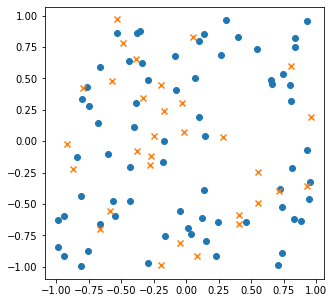

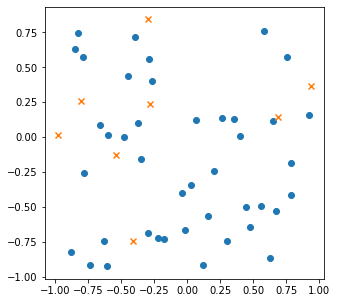

In [77]:
fig, ax = plt.subplots(figsize=(5,5))
eval_points = (rand_sample, None)
corr_bool = np.round(np.random.uniform(0,2, len(rand_sample))).astype(bool)
ax.scatter(eval_points[0].numpy()[corr_bool, 0], eval_points[0].numpy()[corr_bool,1], c='C0', marker='o', label='Pos-test')
ax.scatter(eval_points[0].numpy()[~corr_bool,0], eval_points[0].numpy()[~corr_bool,1], c='C1', marker='x', label='Neg-test')

fig, ax = plt.subplots(figsize=(5,5))
eval_points = (initial_data.query_points, None)
corr_bool = np.round(np.random.uniform(0,2, len(initial_data.query_points))).astype(bool)
ax.scatter(eval_points[0].numpy()[corr_bool, 0], eval_points[0].numpy()[corr_bool,1], c='C0', marker='o', label='Pos-test')
ax.scatter(eval_points[0].numpy()[~corr_bool,0], eval_points[0].numpy()[~corr_bool,1], c='C1', marker='x', label='Neg-test')



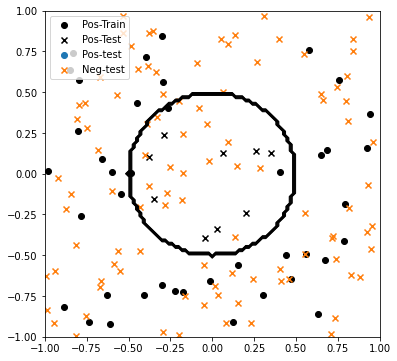

In [78]:
if initial_data.query_points.shape[-1]==1:
    plot_model(online_model, eval_points=(xx,y), 
               train_data=(initial_data.query_points, initial_data.observations), 
               sampled_data=None,
               ground_truth=(X_truth.reshape(-1,1), y_truth.reshape(-1,1)))
else:
    plot_circle(online_model, 
                eval_points=(rand_sample,None),
                train_data=(initial_data.query_points, initial_data.observations),
                contours=True, ground_truth=True)


In [79]:
from bayessian_opt_orig import BayesianOptimizer as BayesianOptimzierOrig

In [80]:
from bayessian_optimizer import BayesianOptimizer

In [81]:
from trieste.acquisition.function import BayesianActiveLearningByDisagreement, ExpectedImprovement, PredictiveVariance
from trieste.acquisition.function import BatchMonteCarloExpectedImprovement, Fantasizer, LocalPenalization, GIBBON


from trieste.acquisition.rule import OBJECTIVE
#from trieste.bayesian_optimizer import BayesianOptimizer

In [82]:
base_acquisition_function_builder=BayesianActiveLearningByDisagreement()

#acq = LocalPenalization(search_space=search_space)
#acq = GIBBON(search_space=search_space)
#acq = BatchMonteCarloExpectedImprovement(sample_size=100)

acq = BayesianActiveLearningByDisagreement()
#acq = PredictiveVariance()
#acq = ExpectedImprovement()


In [83]:
rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq, num_query_points=1)  # type: ignore

In [84]:
qp = rule.acquire(search_space, 
                  {OBJECTIVE:online_model},
                  {OBJECTIVE:initial_data})

In [85]:
qp

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[-0.81940684,  0.68441586]])>

In [86]:
points = rule._optimizer(search_space, rule._acquisition_function)

In [87]:
points

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[ 0.31689813, -0.79503129]])>

In [88]:
# final_dataset.query_points
# TODO add visualization of last queried points
# TODO study how noise parameter affects this

In [89]:
num_steps = 10
num_samples = 5
train_data= initial_data 

In [90]:
bo = BayesianOptimizer(observer="Placeholder", search_space=search_space, track_state=True, acquisition_rule=rule)

In [91]:
qp = bo.request_query_points(datasets=train_data, models=online_model, fit_model=True, fit_initial_model=True)

In [92]:
qp

<tf.Tensor: shape=(1, 2), dtype=float64, numpy=array([[0.15216893, 0.5127629 ]])>

In [93]:
ob = init_fun(qp)

In [94]:
ob

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[1.]])>

In [95]:
bo._datasets

{'OBJECTIVE': Dataset(query_points=<tf.Tensor: shape=(50, 2), dtype=float64, numpy=
 array([[ 0.35288787,  0.12713351],
        [ 0.30115396, -0.74245174],
        [ 0.44326049, -0.49668943],
        [-0.59758331,  0.01361262],
        [-0.62818419, -0.74498238],
        [-0.28530688,  0.23681382],
        [ 0.15629626, -0.56076638],
        [ 0.68765429,  0.14611908],
        [-0.17603745, -0.72403481],
        [-0.73591899, -0.91223837],
        [-0.61105953, -0.92367227],
        [ 0.12263832, -0.91021502],
        [-0.48234904,  0.0025975 ],
        [-0.40937566, -0.74333486],
        [-0.37506117,  0.0996652 ],
        [-0.65871355,  0.08828255],
        [ 0.79093985, -0.18274211],
        [-0.54321624, -0.12707958],
        [-0.29809518,  0.84307598],
        [-0.39549407,  0.71733441],
        [ 0.67183279, -0.52705835],
        [-0.80193493,  0.25960357],
        [ 0.92717178,  0.15662243],
        [ 0.47355688, -0.64265811],
        [-0.8842163 , -0.81902951],
        [ 0.6291

In [96]:
bo.optimize_step(query_points=qp, observer_output=ob, fit_model=True)

Optimization completed without errors


In [98]:
bo.result.try_get_final_models()

{'OBJECTIVE': VariationalGaussianProcess(<gpflow.models.vgp.VGP object at 0x7991663a7e50>, Optimizer(optimizer=<gpflow.optimizers.scipy.Scipy object at 0x79916625b7f0>, minimize_args={}, compile=True))False, None, 1000)}

In [52]:
observer

<function trieste.objectives.utils.mk_observer.<locals>.<lambda>(qp)>

In [30]:
train_data= initial_data 

<class 'trieste.data.Dataset'> <class 'trieste.data.Dataset'>
Dataset(query_points=<tf.Tensor: shape=(50, 2), dtype=float64, numpy=
array([[-0.11740193, -0.74315959],
       [-0.95880251, -0.75851179],
       [-0.44792265, -0.35702265],
       [-0.25464565, -0.50276216],
       [-0.32623582, -0.14348086],
       [ 0.56186271, -0.694906  ],
       [ 0.670842  , -0.0104678 ],
       [ 0.97949982, -0.64030708],
       [ 0.82774   , -0.11143251],
       [ 0.94135829, -0.29011542],
       [-0.97557569, -0.78236502],
       [ 0.64201101,  0.44096405],
       [ 0.91055868,  0.71318724],
       [-0.08998223,  0.25987686],
       [ 0.07495248, -0.04595454],
       [ 0.58398182,  0.50947242],
       [-0.32826623,  0.73806111],
       [ 0.52983355, -0.83847073],
       [-0.22255716,  0.71030639],
       [-0.02576571, -0.92565086],
       [ 0.7135974 , -0.41240366],
       [-0.44094105,  0.54305662],
       [-0.2867415 ,  0.5805684 ],
       [-0.96728596,  0.16266593],
       [-0.78469219,  0.7622

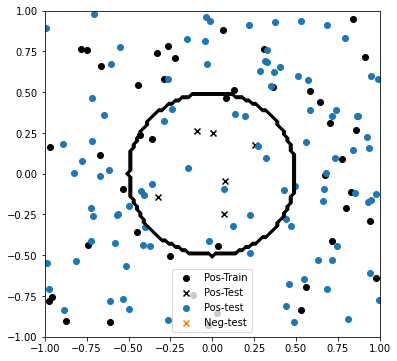

In [33]:
bo = BayesianOptimzierOrig(observer, search_space)
for _ in range(1):
    results = bo.optimize(num_samples, train_data, online_model, rule, fit_initial_model=True)
    print(len(results.history))
    final_dataset = results.try_get_final_datasets()[OBJECTIVE]
    final_model = results.try_get_final_models()[OBJECTIVE]
    if initial_data.query_points.shape[-1]==1:
        plot_model(final_model,
                   eval_points=(xx,y),
                   train_data=(initial_data.query_points, initial_data.observations),
                   sampled_data=(final_dataset.query_points[len(initial_data):], final_dataset.observations[len(initial_data):]),
                   ground_truth=(X_truth.reshape(-1,1), y_truth.reshape(-1,1)))
    else:
        plot_circle(final_model, eval_points=(rand_sample, None),
                    train_data=(initial_data.query_points, initial_data.observations),
                    contours=True,
                    ground_truth=True)

    train_data = final_dataset
    online_model = final_model
    

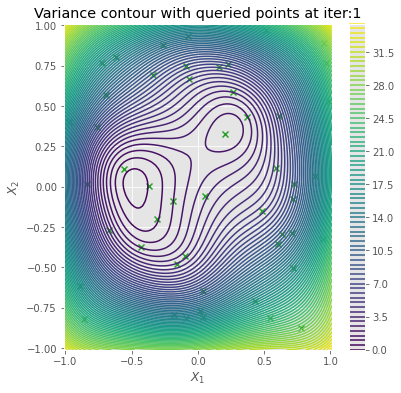

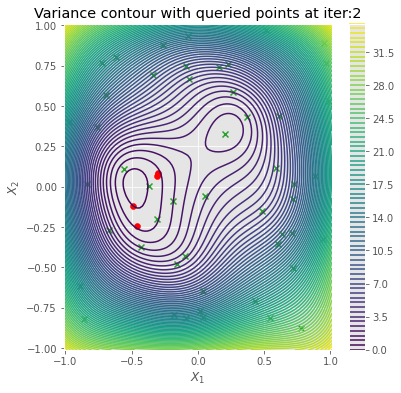

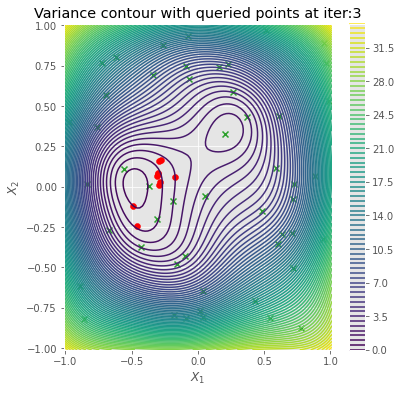

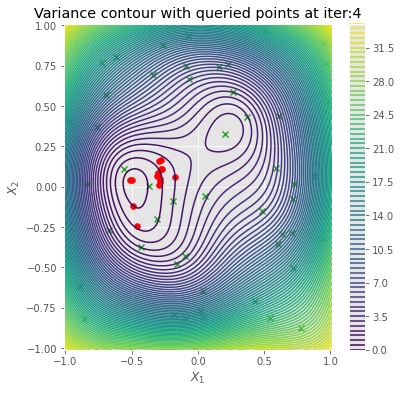

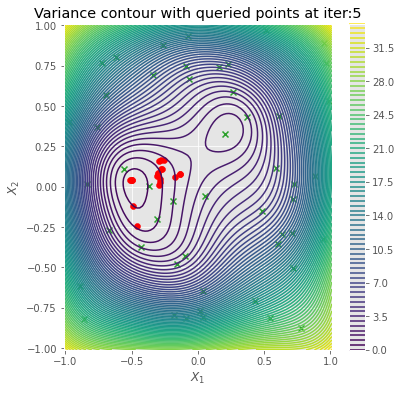

In [58]:
from trieste.experimental.plotting import plot_bo_points, plot_function_2d
from typing import Callable, List, Optional, Sequence, Union

def format_point_markers_sampling(
    num_pts: int,
    num_init: Optional[Union[int, TensorType]] = None,
    idx_best: Optional[TensorType] = None,
    m_init: str = "x",
    m_add: str = "o",
    c_init: str = "tab:green",
    c_add: str = "tab:red",
    c_best: str = "tab:purple") -> tuple[TensorType, TensorType]:
    """
    Prepares point marker styles according to some BO factors.

    :param num_pts: total number of BO points
    :param num_init: initial number of BO points; can also be a mask
    :param idx_best: index of the best BO point(s)
    :param mask_fail: Bool vector, True if the corresponding observation violates the constraint(s)
    :param m_init: marker for the initial BO points
    :param m_add: marker for the other BO points
    :param c_pass: color for the regular BO points
    :param c_fail: color for the failed BO points
    :param c_best: color for the best BO points
    :return: 2 string vectors col_pts, mark_pts containing marker styles and colors
    """
    if num_init is None:
        num_init = num_pts
        
    col_pts = np.repeat(c_init, num_pts)
    col_pts = col_pts.astype("<U15")
    
    mark_pts = np.repeat(m_init, num_pts)
    
    if isinstance(num_init, int):
        mark_pts[num_init:] = m_add
        col_pts[num_init:] = c_add
    else:
        mark_pts[np.where(~num_init)] = m_add
        col_pts[np.where(~num_init)] = c_add

    if idx_best is not None:
        col_pts[idx_best] = c_best

    return col_pts, mark_pts
    
def plot_bo_points(
    pts: TensorType,
    ax: Axes,
    num_init: Optional[Union[int, TensorType]] = None,
    idx_best: Optional[int] = None,
    mask_fail: Optional[TensorType] = None,
    obs_values: Optional[TensorType] = None,
    m_init: str = "x",
    c_init: str = 'tab:green',
    m_add: str = "o",
    c_add: str = 'r',
    c_pass: str = "tab:green",
    c_fail: Union[str, List[str]] = "tab:red",
    c_best: str = "tab:purple",
    sampling_plot: Optional[bool] = False,
) -> None:
    """
    Adds scatter points to an existing subfigure. Markers and colors are chosen according to
    BO factors.

    :param pts: [N, 2] x inputs
    :param ax: a plt axes object
    :param num_init: initial number of BO points; can also be a mask
    :param idx_best: index of the best BO point
    :param mask_fail: Bool vector, True if the corresponding observation violates the constraint(s)
    :param obs_values: optional [N] outputs (for 3d plots)
    :param m_init: marker for the initial BO points
    :param m_add: marker for the other BO points
    :param c_pass: color for the regular BO points
    :param c_fail: color for the failed BO points
    :param c_best: color for the best BO points
    """

    num_pts = pts.shape[0]
    if sampling_plot:
        col_pts, mark_pts = format_point_markers_sampling(num_pts, num_init, idx_best, m_init, m_add, c_init, c_add)
    else:
        col_pts, mark_pts = format_point_markers(
            num_pts, num_init, idx_best, mask_fail, m_init, m_add, c_pass, c_fail, c_best
        )

    if obs_values is None:
        for i in range(pts.shape[0]):
            ax.scatter(pts[i, 0], pts[i, 1], c=col_pts[i], marker=mark_pts[i])
    else:
        for i in range(pts.shape[0]):
            ax.scatter(pts[i, 0], pts[i, 1], obs_values[i], c=col_pts[i], marker=mark_pts[i])

def plot_active_learning_query(result, bo_iter, num_initial_points, query_points, num_query=1):
    for i in range(bo_iter):
        def pred_var(x):
            _, var = result.history[i].models["OBJECTIVE"].model.predict_f(x)
            return var

        _, ax = plot_function_2d(
            pred_var,
            search_space.lower - 0.01,
            search_space.upper + 0.01,
            contour=True,
            colorbar=True,
            figsize=(6, 6),
            title=[
                "Variance contour with queried points at iter:" + str(i + 1)
            ],
            xlabel="$X_1$",
            ylabel="$X_2$",
        )

        plot_bo_points(
            query_points[: num_initial_points + (i * num_query)],
            ax[0, 0],
            num_initial_points,
            sampling_plot=True
        )

plot_active_learning_query(result=results, bo_iter=5, num_initial_points=len(initial_data),
                           query_points=final_dataset.query_points.numpy(),
                          num_query=num_samples)

In [224]:
results.history[0].model.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.mean_function.c,Parameter,Identity,,True,(),float64,16.40532
VGP.kernel.variance,Parameter,Softplus,,False,(),float64,100.0
VGP.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(2,)",float64,[0.97122245 1.03462 ]
VGP.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[-8.72035476e-01, 2.82507721e-01..."
VGP.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGP.num_data,Parameter,Identity,,False,(),int32,95
VGP.q_mu,Parameter,Identity,,True,"(None, 1)",float64,[[-4.78181623e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, None, None)",float64,"[[[3.64270988e-01, 0.00000000e+00, 0.00000000e+00..."


╒═════════════════════════╤══════════════════╤════════════════╤═══════════╤═════════════╤═════════════════╤═════════╤═══════════════════════════════════════════════════════╕
│ name                    │ class            │ transform      │ prior     │ trainable   │ shape           │ dtype   │ value                                                 │
╞═════════════════════════╪══════════════════╪════════════════╪═══════════╪═════════════╪═════════════════╪═════════╪═══════════════════════════════════════════════════════╡
│ VGP.mean_function.c     │ Parameter        │ Identity       │           │ True        │ ()              │ float64 │ 16.30512                                              │
├─────────────────────────┼──────────────────┼────────────────┼───────────┼─────────────┼─────────────────┼─────────┼───────────────────────────────────────────────────────┤
│ VGP.kernel.variance     │ Parameter        │ Softplus       │           │ False       │ ()              │ float64 │ 100.0       

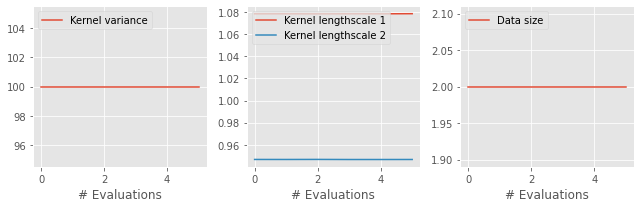

In [60]:
gpflow.utilities.print_summary(
    results.try_get_final_model().model  # type: ignore
)

variance_list = [
    step.model.model.kernel.variance.numpy()  # type: ignore
    for step in results.history + [results.final_result.unwrap()]
]

ls_list = [
    step.model.model.kernel.lengthscales.numpy()  # type: ignore
    for step in results.history + [results.final_result.unwrap()]
]

dataset_length = [
    len(step.model.model.data) 
    for step in results.history + [results.final_result.unwrap()]
]
variance = np.array(variance_list)
ls = np.array(ls_list)

fig, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].plot(variance, label="Kernel variance")
ax[0].legend(loc="upper left")
ax[0].set_xlabel("# Evaluations")
ax[0].set_xlabel("# Evaluations")

ax[1].plot(ls[:, 0], label="Kernel lengthscale 1")
ax[1].plot(ls[:, 1], label="Kernel lengthscale 2")
ax[1].legend(loc="upper left")
ax[1].set_xlabel("# Evaluations")

ax[2].plot(dataset_length, label="Data size")
ax[2].legend(loc="upper left")
ax[2].set_xlabel("# Evaluations")

fig.tight_layout()

In [61]:
elbo = tf.function(online_model.elbo)
tensor_data = tuple(map(tf.convert_to_tensor, (X_scaled, y)))
elbo(tensor_data)  # run it once to trace & compile

AttributeError: 'VariationalGaussianProcess' object has no attribute 'elbo'

In [62]:
gpflow.set_trainable(online_model.inducing_variable, False)

def run_adam(model, dataset, early_stop=False, stop_win=5, iterations=100, mini_batch_size=32):
    logf = []
    train_iter = iter(dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            ypreds, yvars = online_model.predict_f(xx)

        if step>stop_win and early_stop:
            if np.mean(lofg[-stop_win:])>-0.1:
                return lofg
                        
    return model, logf

AttributeError: 'VariationalGaussianProcess' object has no attribute 'inducing_variable'

In [ ]:
maxiter=1000
online_model, logf = run_adam(model=online_model, dataset=train_dataset, iterations=maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [ ]:
# Loop for incremental updates
for i in range(0, len(X_scaled), minibatch_size):
    # Select minibatch
    X_batch = X_scaled[i:i+minibatch_size]
    y_batch = y[i:i+minibatch_size]

    # Update the model with the minibatch
    online_model_data = online_model.data
    online_model_data = (np.vstack([online_model_data[0], X_batch.reshape(-1, 1)]), np.vstack([online_model_data[1], y_batch.reshape(-1, 1)]))
    online_model.data = online_model_data

    # Optimize the model parameters
    gpflow.optimizers.Scipy().minimize(online_model.training_loss, online_model.trainable_variables)

In [150]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import trieste
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import OBJECTIVE
from trieste.models.gpflow.models import VariationalGaussianProcess, SparseGaussianProcessRegression
from trieste.objectives.utils import mk_observer

np.random.seed(1793)
tf.random.set_seed(1793)

In [71]:
search_space = trieste.space.Box([-1, -1], [1, 1])
input_dim = 2


def circle(x):
    return tf.cast(
        (tf.reduce_sum(tf.square(x), axis=1, keepdims=True) - 0.5) > 0,
        tf.float64,
    )

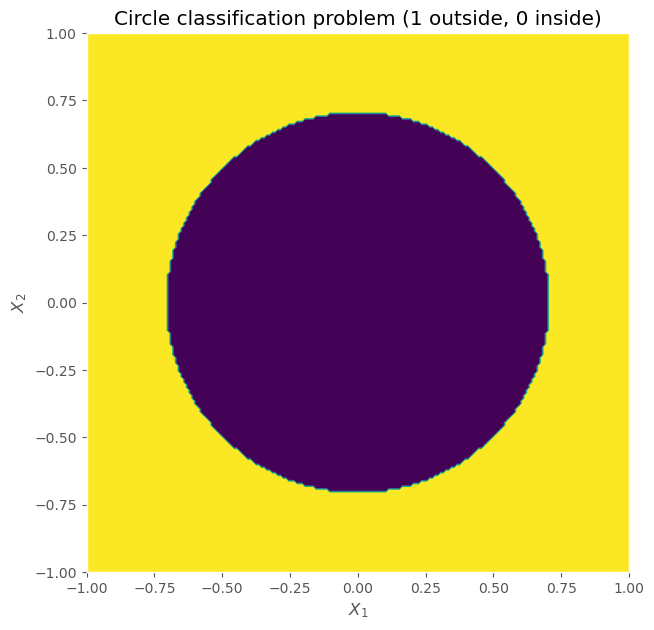

In [72]:
from trieste.experimental.plotting import plot_function_2d

_, ax = plot_function_2d(
    circle,
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    figsize=(7, 7),
    title=["Circle classification problem (1 outside, 0 inside)"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plt.show()

In [73]:
num_initial_points = 5
X = search_space.sample(num_initial_points)
observer = mk_observer(circle)
initial_data = observer(X)

In [103]:
from trieste.models.gpflow import VariationalGaussianProcess
from trieste.models.gpflow.builders import build_vgp_classifier

model = VariationalGaussianProcess(
    build_vgp_classifier(initial_data, search_space, noise_free=True)
)

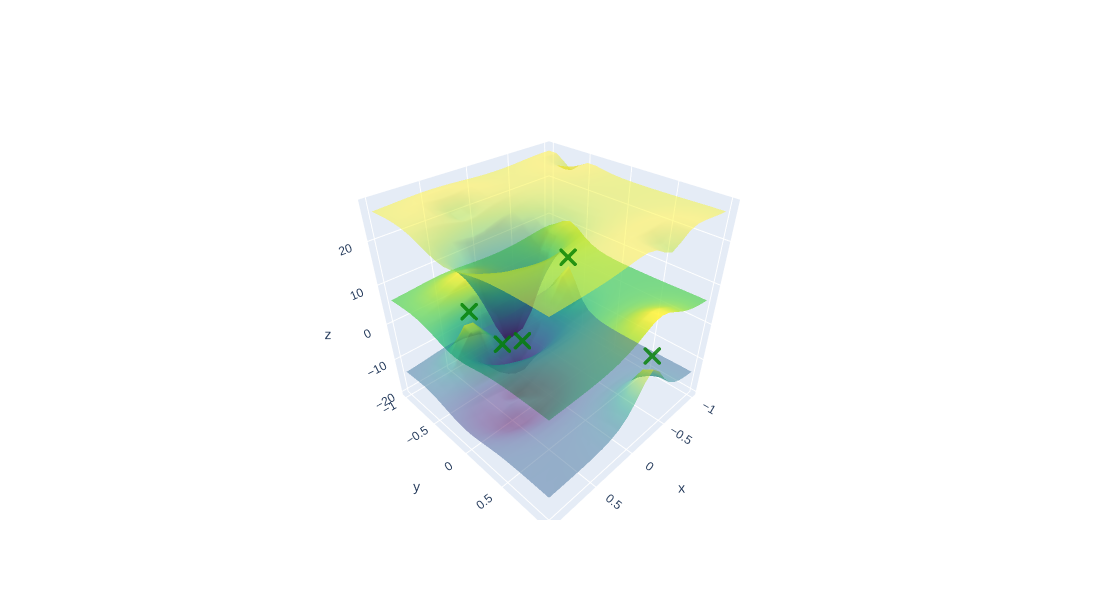

In [104]:
from trieste.experimental.plotting import (
    plot_model_predictions_plotly,
    add_bo_points_plotly,
)

model.update(initial_data)
model.optimize(initial_data)

fig = plot_model_predictions_plotly(
    model,
    search_space.lower,
    search_space.upper,
)

fig = add_bo_points_plotly(
    x=initial_data.query_points[:, 0],
    y=initial_data.query_points[:, 1],
    z=initial_data.observations[:, 0],
    num_init=num_initial_points,
    fig=fig,
    figrow=1,
    figcol=1,
)
fig.show()

In [105]:
acq = BayesianActiveLearningByDisagreement()
rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq)  # type: ignore

In [106]:
num_steps = 30
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)
results = bo.optimize(num_steps, initial_data, model, rule)
final_dataset = results.try_get_final_datasets()[OBJECTIVE]
final_model = results.try_get_final_models()[OBJECTIVE]

Optimization completed without errors


In [107]:
colors = ['C0'  if v==1 else 'C1' for v in final_dataset.observations]

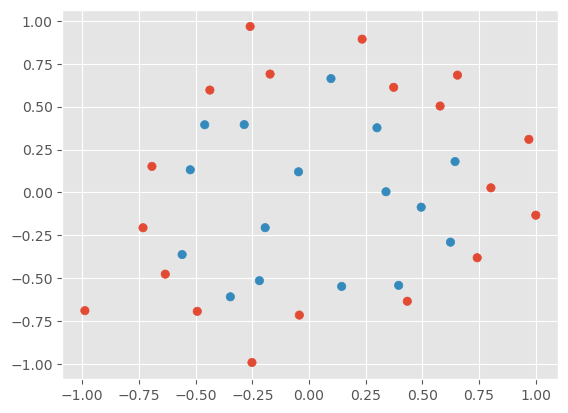

In [108]:

plt.scatter(final_dataset.query_points.numpy()[:,0],
            final_dataset.query_points.numpy()[:,1],
            c=colors)

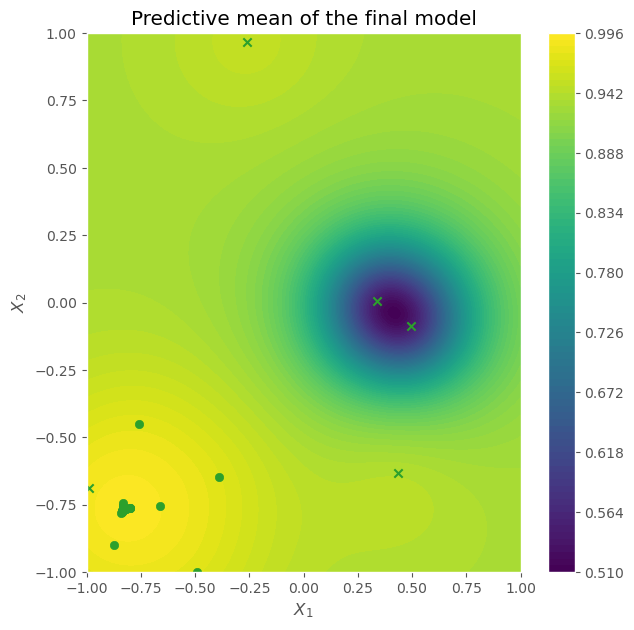

In [83]:
from trieste.experimental.plotting import plot_bo_points

_, ax = plot_function_2d(
    lambda x: gpflow.likelihoods.Bernoulli().invlink(final_model.predict(x)[0]),
    search_space.lower,
    search_space.upper,
    grid_density=200,
    contour=True,
    colorbar=True,
    figsize=(7, 7),
    title=["Predictive mean of the final model"],
    xlabel="$X_1$",
    ylabel="$X_2$",
    fill=True,
)
plot_bo_points(final_dataset.query_points, ax[0, 0], num_initial_points)
plt.show()